# NYC Subway Dataset Analysis

## Assignment

Purpose of this assignment is to analyze subway ridership dataset and see if external elements like rain significantly influence the number of passengers.  
Also, we need to predict number of passengers based on parameters we previously analyzed.

## Disclaimers

Part of the this assigment are also questions in Problem Sets 2, 3, and 4 in the Introduction to Data Science course.  
I have resolved all of those.  
On couple of them, server would return some unrelated errors and my submission would fail even though I did get required plots.  
This only happens when dealing with ggplot.

## Loading Data and Defining Functions

## Section 0. References

1. Udacity "Intro to Data Science" videos
2. pandas, numpy, sklearn, ggplot documentation
3. http://matplotlib.org/users/pyplot_tutorial.html
4. http://matplotlib.org/examples/api/barchart_demo.html
5. https://www.youtube.com/watch?v=pHrwqLhAaMw
6. http://stackoverflow.com/questions/2546016/how-to-define-fill-colours-in-ggplot-histogram

## Section 1. Statistical Test

### Question 1.1
Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

#### Answer
**H0: µ_entries_rain = µ_entries_no_rain**  
Mean of entries on the days it rains is the same as the mean of entries on the days when it doesn't rain  
**H1: µ_entries_rain ≠ µ_entries_no_rain**  
Mean of entries on the days it rains is different than the mean of entries on the days when it doesn't rain  
  
I am using two-tail p value.

p_critical = 0.05  
  
I used Mann-Whitney u-test since the data was not normally distributed.

#### Calculation
First we need to agregate *entries* and *rain* by days.

In [1]:
import numpy as np
import pandas
import pandasql
from sklearn.linear_model import SGDRegressor
import scipy
from ggplot import *
%matplotlib inline 

pandas.set_option('display.max_columns', None)
data = pandas.read_csv('data/weather.csv')
#print data.iloc[0]

In [2]:
q = """
select UNIT, DATEn, max(rain) as rain, weekday, sum(ENTRIESn_hourly) as entries
from data
group by UNIT, DATEn
"""

daily_data = pandasql.sqldf(q, locals())

Now we can compare entries on the days that rains vs. the ones that don't.  
Also, we should compare only weekdays with themselves since ridership may vary for weekends.

In [3]:
rains_weekday_data = daily_data['entries'][(daily_data.rain == 1) & (daily_data.weekday == 1)]
no_rain_weekday_data = daily_data['entries'][(daily_data.rain == 0) & (daily_data.weekday == 1)]
rains_weekend_data = daily_data['entries'][(daily_data.rain == 1) & (daily_data.weekday == 0)]
no_rain_weekend_data = daily_data['entries'][(daily_data.rain == 0) & (daily_data.weekday == 0)]

To detect which test we should use we first need to confirm or deny some assumptions we have about data.
First we use Shapiro-Wilk test to see weather our data is normally distributed.

In [4]:
w,p = scipy.stats.shapiro(daily_data['entries'])
print "p = " + str(p)

p = 0.0


/home/veich/installations/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1082: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Since p = 0.0 we can conclude that our data is not normally distributed.

stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.


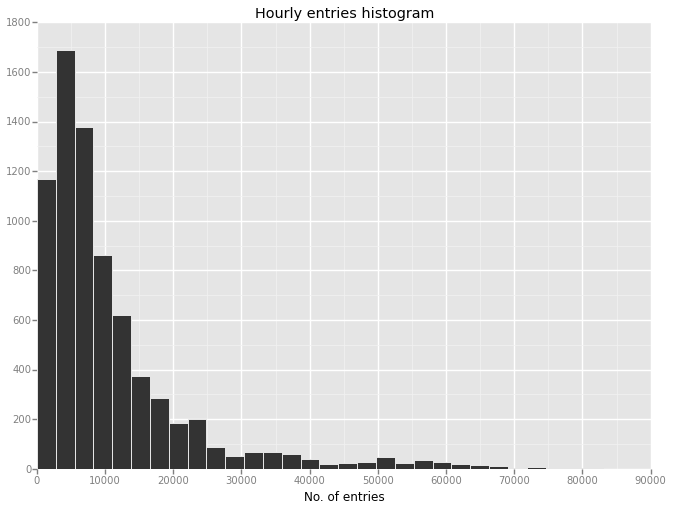

<ggplot: (8789795076837)>

In [5]:
ggplot(daily_data, aes(x="entries")) + geom_histogram() + \
ggtitle("Hourly entries histogram") + \
xlab('No. of entries')

Because our data is not normally distributed Mann-Whitney u-test seems appropriate to compare data samples.  
This test doesn't assume any particular probability distribution.

### Question 1.2
Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

#### Answer
Mann-Whitney u-test doesn't assume any particular sample distribution which makes it suitable for this data set which is not normally distributed.

### Question 1.3
What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [23]:
u,p = scipy.stats.mannwhitneyu(rains_weekday_data, no_rain_weekday_data)
two_tail_test_multiplier = 2.0
print 'p = ' + str(p * two_tail_test_multiplier)
print "entries_mean_weekday_rains_ridership = " + str(np.mean(rains_weekday_data))
print "entries_mean_weekday_no_rain_ridership = " + str(np.mean(no_rain_weekday_data))

p = 0.0993775565274
entries_mean_weekday_rains_ridership = 12970.4450995
entries_mean_weekday_no_rain_ridership = 12328.3840246


Calculated p value is higher than our p_critical value (0.05) which means rain has no significant impact on ridership on weekdays.

In [24]:
u,p = scipy.stats.mannwhitneyu(rains_weekend_data, no_rain_weekend_data)
print 'p = ' + str(p * two_tail_test_multiplier)
print "entries_mean_weekend_rains_ridership = " + str(np.mean(rains_weekend_data))
print "entries_mean_weekend_no_rain_ridership = " + str(np.mean(no_rain_weekend_data))

p = 0.165990177612
entries_mean_weekend_rains_ridership = 6193.14814815
entries_mean_weekend_no_rain_ridership = 6939.72384035


p value in this test suggests that rain has no significant impact on subway ridership during the weekend.

In [25]:
u,p = scipy.stats.mannwhitneyu(rains_weekday_data, rains_weekend_data)
print 'p = ' + str(p * two_tail_test_multiplier)
print "entries_mean_weekday_rains_ridership = " + str(np.mean(rains_weekday_data))
print "entries_mean_weekend_rains_ridership = " + str(np.mean(rains_weekend_data))
u,p = scipy.stats.mannwhitneyu(no_rain_weekend_data, no_rain_weekday_data)
print 'p = ' + str(p * two_tail_test_multiplier)
print "entries_mean_weekday_no_rain_ridership = " + str(np.mean(no_rain_weekday_data))
print "entries_mean_weekend_no_rain_ridership = " + str(np.mean(no_rain_weekend_data))

p = 1.53632449262e-31
entries_mean_weekday_rains_ridership = 12970.4450995
entries_mean_weekend_rains_ridership = 6193.14814815
p = 1.52017091941e-102
entries_mean_weekday_no_rain_ridership = 12328.3840246
entries_mean_weekend_no_rain_ridership = 6939.72384035


Calculated p values suggest weekday vs. weekend has significant impact on the subway ridership (accounted for the possible rain impact on the results).

### Question 1.4
What is the significance and interpretation of these results?

#### Answer
Statistical significance of these results is 0.05

## Section 2. Linear Regression

### Question 2.1
What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
- OLS using Statsmodels or Scikit Learn
- Gradient descent using Scikit Learn
- Or something different?

#### Answer
I used gradient descent from scikit learn.

### Question 2.2
What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

#### Answer
In my model I used the following variables (all of them as dummy variables):
- UNIT
- hour
- day_week

#### Calculation

In [9]:
def linear_regression(features, values):
    model = SGDRegressor()
    model.fit(features, values)

    intercept = model.intercept_
    params = model.coef_
    
    return intercept, params

In [10]:
def normalize_features(features):
    ''' 
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    ''' 
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    
    return means, std_devs, normalized_features

In [11]:
def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    
    return intercept, params

In [12]:
def compute_r_squared(data, predicted_data):
    
    y = data['ENTRIESn_hourly'].tolist()
    avg_y = np.mean(y)
    
    
    top_diff = y - predicted_data
    top_diff_squared = top_diff * top_diff
    top_total_sum = np.sum(top_diff_squared)
    
    bottom_diff = y - avg_y
    bottom_diff_squared = bottom_diff * bottom_diff
    bottom_total_sum = np.sum(bottom_diff_squared)
    
    r_squared = 1 - (top_total_sum / bottom_total_sum)
    
    
    return r_squared

In [37]:
def predictions(dataframe): 
    
    features = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    dummy_units = pandas.get_dummies(dataframe['day_week'], prefix='day_week')
    features = features.join(dummy_units)
    dummy_units = pandas.get_dummies(dataframe['hour'], prefix='hour')
    features = features.join(dummy_units)
    
    
    #print dummy_units
    
    # Values
    values = dataframe['ENTRIESn_hourly']
    
    # Get numpy arrays
    features_array = features.values
    values_array = values.values
    
    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent
    norm_intercept, norm_params = linear_regression(normalized_features_array, values_array)
    
    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)
    
    predictions = intercept + np.dot(features_array, params)
    # The following line would be equivalent:
    # predictions = norm_intercept + np.dot(normalized_features_array, norm_params)
    
    global data_intercept
    data_intercept = intercept
    
    global data_params
    data_params = params
    
    return predictions

In [38]:
data_intercept = []
data_params = []
entries_predictions = predictions(data)

r_squared = compute_r_squared(data, entries_predictions)
print "r_squared: " + str(r_squared)
#print data.iloc[0]

r_squared: 0.5275874932


### Question 2.3
Why did you select these features in your model? We are looking for specific reasons that lead you to believe that
the selected features will contribute to the predictive power of your model.
- Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.”
- Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”

#### Answer

Feature selection was based both on data analysis and experimentation.  
  
Variables based on analysis:
- weekday (which later turned out to be redundant to day_week variable)
  
Features based on experimentation and incresasing R^2 value:
- hour
- day_week


### Question 2.4
What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

In [15]:
print 'intercept: '
print data_intercept
print 'params: '
print data_params

intercept: 
[ 2389.20203747]
params: 
[ -7.71847093e+00  -1.42720189e+03  -1.19618447e+03  -1.24296455e+03
  -1.33869534e+03  -1.09946308e+03  -1.87003549e+03  -1.87718297e+03
   5.77156847e+03   5.49263772e+03   8.25431965e+02  -1.13472599e+03
   1.50693061e+03   5.48138828e+03   2.15400901e+03   5.63577165e+03
   4.47178337e+03   8.06108113e+03   5.11057810e+03   1.65987759e+03
   2.19532298e+03   2.15234662e+03   6.48509164e+03   8.59287025e+02
   2.30768215e+03   5.10189189e+03   5.92669298e+03  -6.59085849e+02
   8.25372345e+02  -1.49266495e+03  -1.12322495e+03  -1.57520773e+03
  -7.59384662e+02  -4.48702501e+02   1.11117746e+03  -9.78371754e+02
   7.59089998e+02   3.43718169e+03   7.36189604e+03   3.80815347e+02
   2.06972753e+03   2.62342227e+03  -6.29139286e+02   1.38957386e+03
  -6.75676668e+02   6.54721446e+03  -3.24625438e+02   2.26524243e+03
  -1.29066123e+03  -9.04692380e+02  -1.15640799e+03  -9.92252929e+02
   8.05079403e+02  -9.52264857e+02  -1.18805372e+03  -1.39733575e

### Question 2.5
What is your model’s R2 (coefficients of determination) value?

#### Answer

In [16]:
print "R2 coefficient: " + str(r_squared)

R2 coefficient: 0.523685749679


### Question 2.6
What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

#### Answer
This R^2 value is not very bad but there is a lot of room for improvement.  
I think that this linear model is not very appropriate for this dataset, and that some other non-linear model might be better.

## Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.
Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

### Question 3.1
One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
- You can combine the two histograms in a single plot or you can use two separate plots.
- If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
- For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
- Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

#### Answer

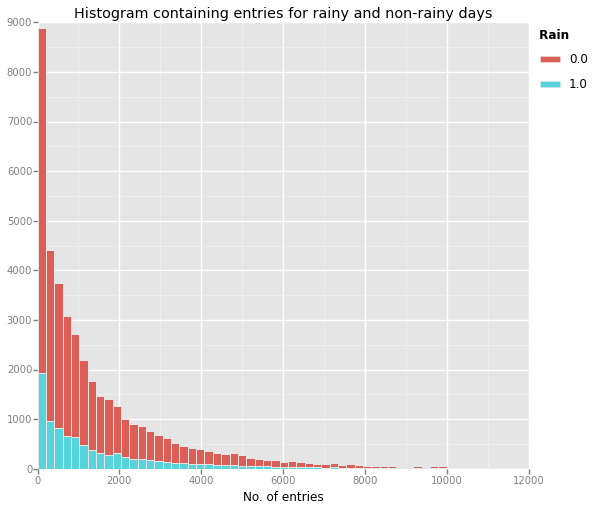

<ggplot: (8789793791169)>

In [21]:
ggplot(data[data['ENTRIESn_hourly'] < 10000], aes(x="ENTRIESn_hourly", fill="rain")) + geom_histogram(binwidth=200) + \
ggtitle("Histogram containing entries for rainy and non-rainy days") + \
xlab('No. of entries')

### Question 3.2
One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
- Ridership by time-of-day
- Ridership by day-of-week

#### Answer

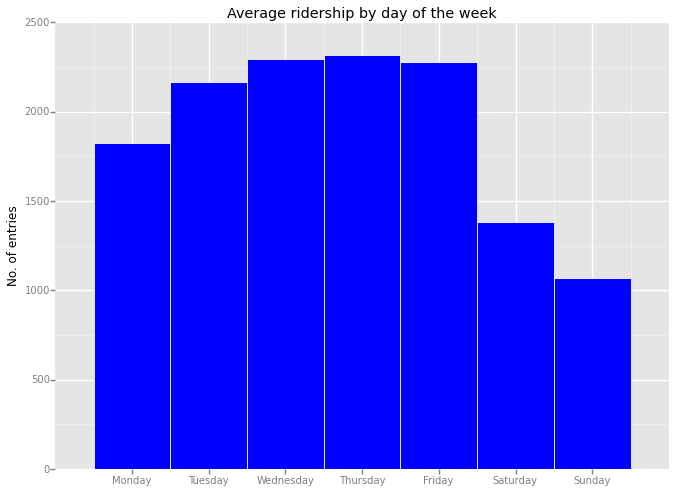

<ggplot: (8789793839117)>

In [18]:
q = """
select day_week, avg(ENTRIESn_hourly) as entries
from data
group by day_week
"""

day_of_week_data = pandasql.sqldf(q, locals())

ggplot(day_of_week_data, aes("day_week", "entries")) + geom_bar(stat="bar", fill="blue") + \
ggtitle('Average ridership by day of the week') + \
ylab('No. of entries') + xlab('') + \
scale_x_continuous(breaks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

/home/veich/installations/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


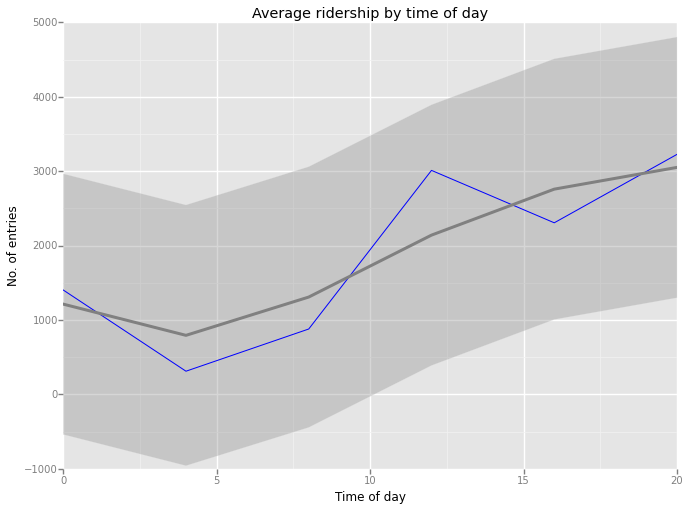

<ggplot: (8789793951985)>

In [19]:
q = """
select hour, avg(ENTRIESn_hourly) as entries
from data
group by hour
"""

time_of_day_data = pandasql.sqldf(q, locals())

ggplot(time_of_day_data, aes("hour", "entries")) + geom_line(color="blue") + stat_smooth(color="gray", size="3") + \
ggtitle('Average ridership by time of day') + \
xlab("Time of day") + ylab('No. of entries')

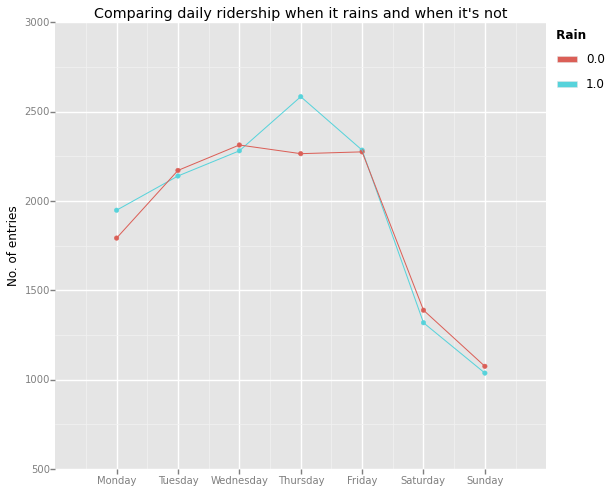

<ggplot: (8789793521837)>

In [22]:
q = """
select rain, day_week, avg(ENTRIESn_hourly) as entries
from data
group by day_week, rain
"""

rain_data = pandasql.sqldf(q, locals())

ggplot(rain_data, aes('day_week', 'entries', color='rain')) + geom_line() + geom_point() + \
ggtitle("Comparing daily ridership when it rains and when it's not") + \
ylab('No. of entries') + xlab('') + \
scale_x_continuous(breaks=range(0,7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

## Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### Question 4.1
From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

#### Answer
Based on my analysis there is no significant change in NYC subway ridership when it's raining as opposed to when it's not raining.

### Question 4.2
What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

#### Answer
First thing that led me to this conclusion was Mann-Whitney u-test I performed on the dataset.
This test returned p value which was higher than p_critical and this led me to conclusion that rain has no significant influence on the ridership.

Secondly, when performing linear regression and calculating R^2 - result did not change at all when including *rain* feature into the model.  
From this conclude that there is no correlation between rain and the ridership.

## Section 5. Reflection

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### Question 5.1
Please discuss potential shortcomings of the methods of your analysis, including:
- Dataset,
- Analysis, such as the linear regression model or statistical test.

#### Answer
Dataset:
- dataset covers only the month of May - other months can have different riderships
- dataset covers only one year - this may not be representative enough for every year
  
Analysis:
- we assume that the right approximation of our model is linear (hence the linear regression) when that doesn't need to be true
- R^2 value suggests that we didn't get particularly precise model

### Question 5.2
(Optional) Do you have any other insight about the dataset that you would like to share with us?

#### Answer
There are many datapoints with ridership equal to zero for entire day which is perhaps only data missing and not ridership zero